In [3]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

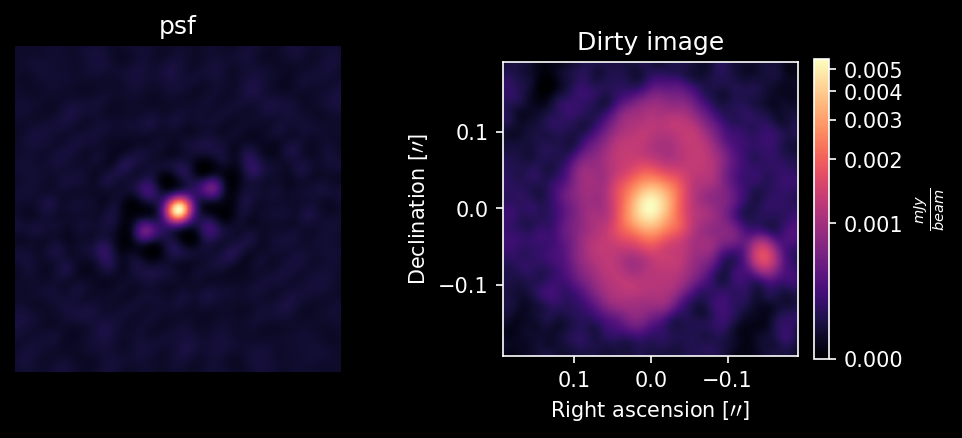

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")


# Observation
ms = "HTLup_continuum0.0015arcsec2"

# Loading the psf and the dirty image
header_psf, psf = fits_to_tensor("../../" + ms + "_psf.fits")
header_dirty, dirty_image = fits_to_tensor("../../" + ms + ".fits") # Jansky/beam Units

vis_gridded = ft(dirty_image/dirty_image.max())  
img_size = vis_gridded.shape[0] # Should be 256

sampling_function = ft(torch.fft.ifftshift(psf)).flatten()
### Physical units: 

# Number of pixels: 
nx = header_dirty["NAXIS1"]
ny = header_dirty["NAXIS2"]

# RA coordinates
CDELT1 = 3600 * header_dirty["CDELT1"] # arcsec 

# DEC coordinates
CDELT2 = 3600 * header_dirty["CDELT2"] # arcsec

# Pixels to physical units
ra =  (np.arange(nx) - nx/2) * CDELT1       
dec = (np.arange(ny) - ny/2) * CDELT2                             

ext = (
    ra[0] - CDELT1/2,
    ra[-1] + CDELT1/2,
    dec[0] - CDELT2/2,
    dec[-1] + CDELT2/2 
)

# Plotting... 
fig, axs = plt.subplots(nrows= 1 , ncols = 2, figsize = (7, 3.5))
axs[0].axis("off")



axs[0].imshow(psf.cpu(), cmap = "magma")
axs[0].set_title("psf")

norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
im = axs[1].imshow((dirty_image).real.cpu(), cmap =  "magma", norm = norm, origin = "lower", extent = ext)
axs[1].set(title = "Dirty image", xlabel = r"Right ascension $[\prime\prime]$", ylabel = r"Declination $[\prime\prime]$")
plt.colorbar(im, fraction = 0.046, label = r"$\frac{mJy}{beam}$")
plt.subplots_adjust(wspace = 0.5)


In [6]:
# To handle pytorch's problem to do differentiation on complex 
y = vis_gridded.flatten()

D = len(y)
sigma_likelihood = 1e-3 # My guess 
beta = 1e-3
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = link_function(x)
    vis_full = ft(x.reshape(img_size, img_size)).flatten()
    sampling_function= ft(torch.fft.ifftshift(psf)).flatten()

    # To prevent problems with grad for complex functions in torch
    real_part = sampling_function.real * vis_full.real - sampling_function.imag * vis_full.imag
    im_part = sampling_function.real * vis_full.imag + sampling_function.imag * vis_full.real
    vis_sampled = real_part + 1j * im_part
    return vis_sampled

S = sampling_function

def logprob_likelihood(x, sigmas): 
    """Calculate the log-likelihood of a Multivariate Gaussian for a diagonal covariance matrix

    Args:
        x: point where we want to compute the log-likelihood
        sigmas: Tensor containing the elements of the diagonal of the covariance matrix 

    Returns:
        log-likelihood
    """

    #inv_cov = torch.diag(1/sigmas)
    val = - (x.conj().t() *1/sigmas) @ x # - D/2 * np.log(2*np.pi) - 1/2 * torch.log(torch.prod(sigmas))
    return val.squeeze(0)


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    I = torch.ones(D).to(device)
    covar_noise = sigma_likelihood**2 * I 
    return vmap(grad(lambda x, t: logprob_likelihood(y -model(x), covar_noise + sigma(t)**2 * (S.abs()**2) + beta * I)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 


tensor(0.0038, device='cuda:0')
tensor([[-0.0019, -0.0078,  0.0032,  ...,  0.0023, -0.0034, -0.0034]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [8]:
sampling_function

tensor([2.1507+0.0000j, 1.3428-0.0003j, 1.2752+0.0014j,  ...,
        1.0498-0.0029j, 1.3916+0.0034j, 1.2860-0.0023j], device='cuda:0')

In [41]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean) * dirty_image.max()

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean) * dirty_image.max()

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 4, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [01:52<00:00,  4.42it/s]


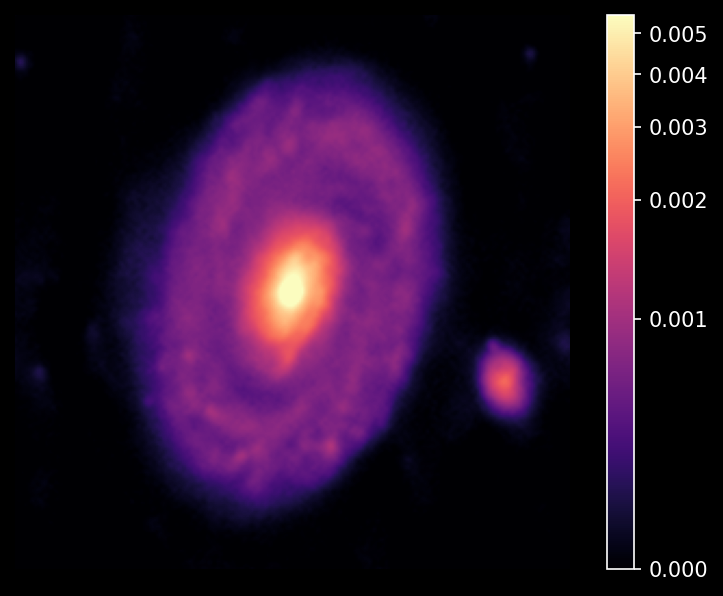

In [42]:
n_images = len(samples)
grid_size = int(n_images**0.5)
norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))

    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()

In [32]:
from astropy.visualization import ImageNormalize, AsinhStretch, LogStretch
import scienceplots
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.io import fits
import colorcet as cc
import numpy as np
import torch
from astropy.wcs import WCS

import sys
sys.path.append("..\\")
from utils import fits_to_tensor
plt.style.use("science") # Need SciencePLots
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 30,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'xtick.major.size': 8,
         'xtick.minor.size': 4,
         'xtick.major.width': 1,
         'xtick.minor.width': 1,
         'ytick.color': "w",
         'xtick.color': "w",
         'axes.labelcolor': "w",
         'ytick.labelcolor' : "w",
         'xtick.labelcolor' : "w",
         }
pylab.rcParams.update(params)
plt.rcParams["text.usetex"] = False
plt.rcParams["figure.dpi"] = 250

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


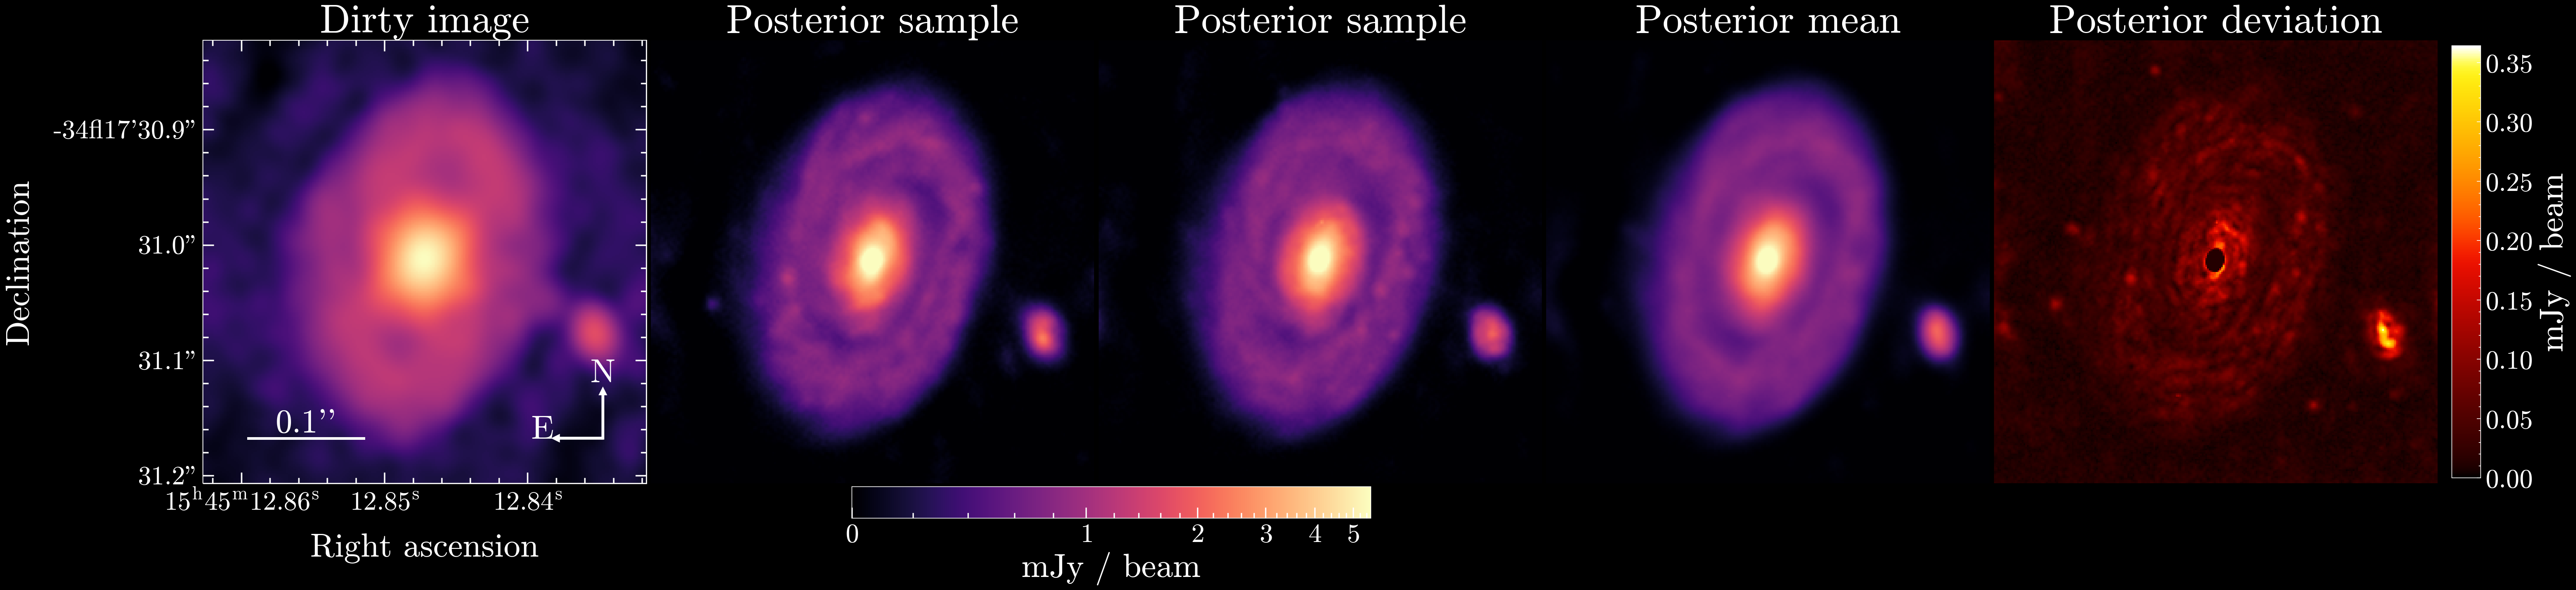

In [33]:
samples = samples.reshape(-1, img_size, img_size)
def draw_scale_and_compass(ax, cutout, wcs, rotation=0, scale=1, x0=0.1, y0=0.1, compass_size=0.1, arrow_size=0.001, color="k", lw=2, textpad=5, fontsize=15):
    hdr = wcs.to_header()
    pixel_scale_x, pixel_scale_y, *_ = proj_plane_pixel_scales(wcs) # in degrees /pixels
    pixel_scale = np.mean([pixel_scale_x, pixel_scale_y]) # for drawing arrows
    M, N = cutout.shape
    
    # nice doc here http://montage.ipac.caltech.edu/docs/headers.html
    # Remember that PC maps pixels to world, so it include a mirror flip of the j coordinate (East-West)
    pc_matrix = wcs.pixel_scale_matrix
    north = np.array([0, 1])
    east = np.array([1, 0]) # accounts for the mirror flip of that coordinate to stay in pixel space
    assert rotation % 90 == 0, "Rotation should only be used for images flipped by 90 or 180 degrees"
    theta = rotation * np.pi / 180 / 2 # divide by two to apply this to the PC matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    pc_matrix = R @ pc_matrix @ R.T
    
    # North arrow 
    ndx = (pc_matrix @ north)[0] * compass_size * N / pixel_scale
    ndy = (pc_matrix @ north)[1] * compass_size * N / pixel_scale
    # East arrow
    edx = (pc_matrix @ east)[0] * compass_size * N / pixel_scale
    edy = (pc_matrix @ east)[1] * compass_size * N / pixel_scale
    # some convenient padding solutions
    nrx = abs(ndx) / np.sqrt(ndx**2 + ndy**2) 
    nry = abs(ndy) / np.sqrt(ndx**2 + ndy**2)
    erx = edx / np.sqrt(edx**2 + edy**2)
    ery = -edy / np.sqrt(edx**2 + edy**2)
    # Orientation of the letters N and E
    angle = (np.arctan2(np.abs(ndy), ndx) - np.pi / 2) * 180 / np.pi
    
    # Scale bar
    ax.plot([x0*N, x0*N + scale/pixel_scale_y/3600], [y0*M, y0*M], linewidth=lw, color=color)
    ax.text(x0*N + scale/pixel_scale_x/2/3600, y0*M+textpad/2, f"{abs(scale)}''", fontsize=fontsize, color=color, ha='center', weight='bold')

    # North arrow, on the bottom right corner, pointing up
    ax.arrow(x=(1 - x0)*N, y=y0*M, dx=ndx, dy=ndy, head_width=abs(arrow_size)*N, head_length=abs(arrow_size)*N, fc=color, ec=color, linewidth=lw)
    ax.text((1 - x0)*N+ndx+textpad*nrx, y0*M+ndy+textpad*nry, "N", color=color, fontsize=fontsize, ha='center', rotation=angle, weight='bold')
    
    # East arrow, on the bottom right corner, pointing left
    ax.arrow(x=(1 - x0)*N, y=y0*M, dx=edx, dy=edy, head_width=abs(arrow_size)*N, head_length=abs(arrow_size)*N, fc=color, ec=color, linewidth=lw)
    ax.text((1 - x0)*N+edx+4*textpad*erx/3, y0*M+edy+4*textpad*ery/3, "E", color=color, fontsize=fontsize, ha='center', rotation=angle, weight='bold')
    return ax

from astropy.wcs import WCS
hdr_dict = {'WCSAXES': 2,
 'CRPIX1': 256 / 2 - 0.5,
 'CRPIX2': 256 / 2 - 0.5,
 'CDELT1': -0.0015 / 3600, # pixel scale
 'CDELT2': 0.0015 / 3600,
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'CTYPE1': 'RA---SIN',
 'CTYPE2': 'DEC--SIN',
 'CRVAL1': 236.3035304583,
 'CRVAL2': -34.29194894083,
 'PV2_1': 0.0,
 'PV2_2': 0.0,
 'LONPOLE': 180.0,
 'LATPOLE': -34.29194894083,
 'RESTFRQ': 230538000000.0,
 'TIMESYS': 'utc',
 'MJDREF': 0.0,
 'DATE-OBS': '2017-05-14T04:29:02.640000',
 'MJD-OBS': 57887.186836111,
 'OBSGEO-X': 2225142.180269,
 'OBSGEO-Y': -5440307.370349,
 'OBSGEO-Z': -2481029.851874,
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'SPECSYS': 'LSRK'}
my_wcs = WCS(hdr_dict)

fig = plt.figure(figsize=(30, 6))
#cmap = cc.cm["CET_CBL3"]
cmap_std = cc.cm["fire"]
cmap = "magma"
#norm = plt.cm.colors.Normalize(vmin=0, vmax=samples.max()) # change so it makes sense with your units
norm_std = ImageNormalize(vmin=0, vmax=samples.std(axis = 0).max()) # also change this as well
norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
wcs = my_wcs # World coordinate system, specified by fits header above

# Dirty Image
img = dirty_image
ax = fig.add_subplot(151, projection=wcs)
im = ax.imshow(img.cpu(), cmap=cmap, norm=norm)
draw_scale_and_compass(ax, img, wcs, scale=0.1, x0=0.1, y0=0.1, compass_size=0.1, arrow_size=0.01, color="w", lw=2, textpad=7, fontsize=25)
ax.tick_params(axis='both', which='both', color='white')
ax.set_ylabel("Declination")
ax.set_xlabel("Right ascension")
ax.set_title("Dirty image")

for i in range(2):
    img = samples[i] # change for a posterior sample
    ax = fig.add_subplot(int(f"15{i+2}"), projection=wcs)
    ax.imshow(img.cpu(), cmap=cmap, norm=norm)
    ax.axis("off")
    ax.tick_params(axis='both', which='both', color='white')
    ax.set_title("Posterior sample")


# Mean image (or mode img)
img = samples.mean(axis = 0)
ax = fig.add_subplot(int(f"154"), projection=wcs)
im1 = ax.imshow(img.cpu(), cmap=cmap, norm=norm)
ax.axis("off")
ax.tick_params(axis='both', which='both', color='white')
ax.set_title("Posterior mean") # or mode

# Standard deviation
img = samples.std(axis = 0)
ax = fig.add_subplot(int(f"155"), projection=wcs)
im2 = ax.imshow(img.cpu(), cmap=cmap_std, norm=norm_std)
ax.axis("off")
ax.tick_params(axis='both', which='both', color='white')
ax.set_title("Posterior deviation") # or mode

cbar_ax = fig.add_axes([0.35, 0.05, 0.18, 0.055])  # Position colorbar at [left, bottom, width, height]
cb1 = plt.colorbar(im1, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_xlabel(r"mJy / beam")

cbar_ax2 = fig.add_axes([0.905, 0.12, 0.01, 0.75])
fig.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_ylabel(r"mJy / beam")

plt.subplots_adjust(hspace=0, wspace=0.01)

In [50]:
sigma = 0.5
test = sigma * torch.randn(size = (10000, 256, 256))

test.std(dim = 0)

tensor([[0.4991, 0.4984, 0.4960,  ..., 0.4960, 0.4991, 0.5010],
        [0.4944, 0.4973, 0.4983,  ..., 0.5012, 0.5049, 0.4973],
        [0.5009, 0.4972, 0.5048,  ..., 0.5020, 0.4975, 0.4975],
        ...,
        [0.4953, 0.4928, 0.4966,  ..., 0.5030, 0.5022, 0.5016],
        [0.5011, 0.4954, 0.4969,  ..., 0.4991, 0.4936, 0.4968],
        [0.4951, 0.4980, 0.5003,  ..., 0.4991, 0.5044, 0.4957]])

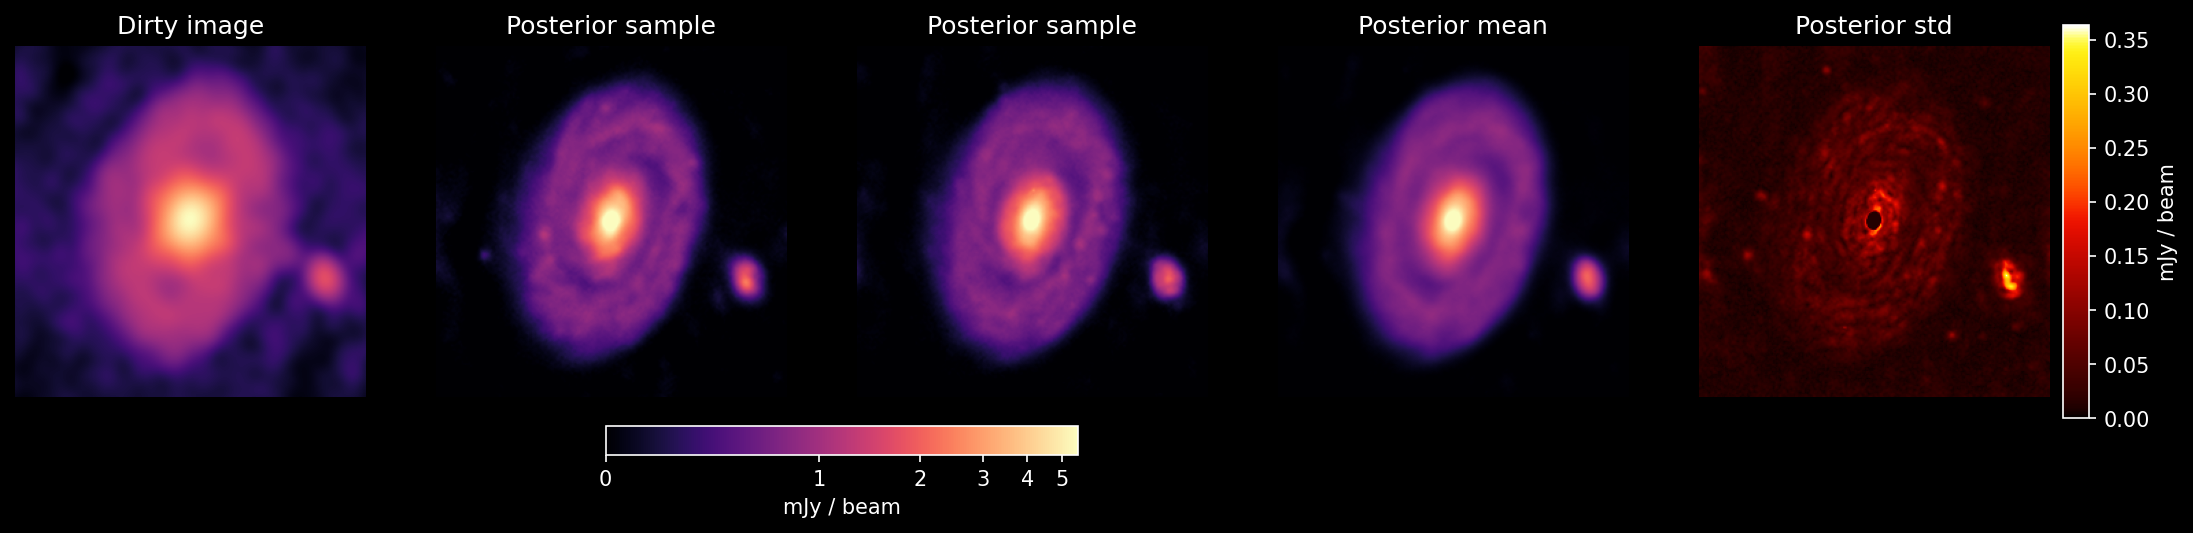

In [24]:
norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
fig, axs = plt.subplots(1, 5, figsize = (5 * 3.5, 3.5))
norm_std = ImageNormalize(vmin=0, vmax=samples.std(axis = 0).max())

for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(dirty_image.cpu(), origin = "lower", cmap = "magma", norm = norm)
axs[0].set(title = "Dirty image")

for i in range(2): 
    im = axs[i+1].imshow(samples[i].cpu().reshape(img_size, img_size), origin = "lower", cmap = "magma", norm = norm)
    axs[i+1].set(title = "Posterior sample")

cbar_ax = fig.add_axes([0.35, 0.05, 0.18, 0.055])
plt.colorbar(im, cbar_ax, orientation = "horizontal")
cbar_ax.set_xlabel(r"mJy / beam")

axs[-2].imshow(samples.mean(axis = 0).reshape(img_size, img_size).cpu(), origin = "lower", cmap = "magma", norm = norm)
axs[-2].set(title = "Posterior mean")
im = axs[-1].imshow(samples.std(axis = 0).reshape(img_size, img_size).cpu(), origin = "lower", cmap = cc.cm["fire"], norm = norm_std)
axs[-1].set(title = "Posterior std")

cbar_ax2 = fig.add_axes([0.905, 0.12, 0.01, 0.75])
plt.colorbar(im, cbar_ax2)
cbar_ax2.set_ylabel(r"mJy / beam")


plt.savefig(f"new_rec{beta}.jpeg", bbox_inches = "tight", pad_inches=0.2)